# Домашняя работа 1 (Кравченко Анатолий):

### Дизайн теста
1. Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

2. Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (0.5 балла)

3. На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (1.5 балла)

4. Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (1 балл)

### A/B тест
1. Представим что у нас прошел тест, используем те же самые данные за 2 недели

2. Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (0.5 балла)

3. Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (0.5 балла)

4. Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (1 балл)

5. Посчитайте результат такого теста и сделайте выводы (2 балла)

Еще 1 балл можно получить за хорошее и подробное объяснение каждого шага

# Подготовка

## Необходимые импорты

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
import datetime
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections
import requests
import zipfile

import os

## Загрузка датасета

In [2]:
url = "https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip"

req = requests.get(url, stream=True)

with open('data_kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:  98%|█████████▊| 77.6M/78.8M [00:01<00:00, 70.8MiB/s]

## Распаковка архива

In [3]:
with zipfile.ZipFile('data_kion.zip', 'r') as zip_ref:
    zip_ref.extractall()

## Чтение данных

In [4]:
interactions = pd.read_csv('data_kion/interactions_df.csv')
users = pd.read_csv('data_kion/users.csv')
items = pd.read_csv('data_kion/items.csv')

In [5]:
interactions

# user_id - уникальный идентификатор пользователя
# item_id - уникальный идентификатор контента
# last_watch_dt - последняя дата просмотра юзером определенного контента
# total_dur - суммарная продолжительность просмотра определенного контента юзером (в секундах)
# watched_pct - процент просмотренного контента от общей продолжительности

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0


In [6]:
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt'])
interactions['user_id'] = interactions['user_id'].astype(str)

# Дизайн теста


## 1. Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

In [7]:
week2 = interactions[(interactions['last_watch_dt'] >= '2021-08-09') & (interactions['last_watch_dt'] <= '2021-08-22')]

In [8]:
print("Самая ранняя дата:", week2['last_watch_dt'].min(), "\nСамая поздняя дата: ", week2['last_watch_dt'].max())

Самая ранняя дата: 2021-08-09 00:00:00 
Самая поздняя дата:  2021-08-22 00:00:00


### 2. Посчитаем на этих данных корректность на бутстрепе и сравним ее с результатами за 1 неделю (посчитано на семинаре)

### У нас есть выбросы, так что удалим их

<Axes: >

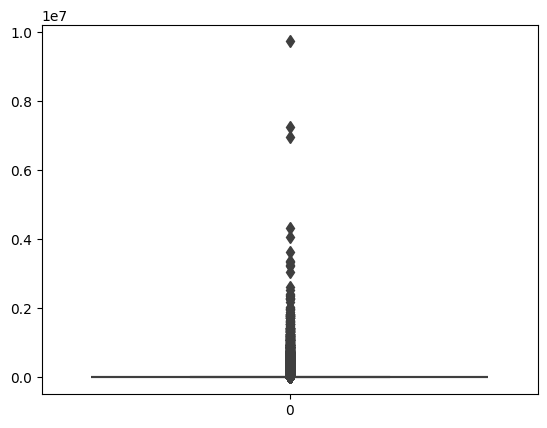

In [9]:
sns.boxplot(week2['total_dur'].values, fliersize=6)

In [10]:
def process_data(data: pd.DataFrame):
    # Группировка данных по 'user_id' и суммирование 'total_dur'
    grouped_data = data.groupby('user_id', as_index=False).agg({'total_dur': 'sum'})
    
    # Фильтрация данных, оставляя только те записи, где 'total_dur' находится в пределах трех стандартных отклонений от среднего
    filtered_data = grouped_data[grouped_data['total_dur'] < grouped_data['total_dur'].std() * 3]
    
    return filtered_data

In [11]:
result = process_data(week2)

In [12]:
result

,user_id,total_dur
0,1,21172
1,1000,10744
2,1000000,32990
3,1000001,52
4,1000003,625
...,...,...
266076,999978,11172
266077,999987,27888
266078,999989,4563
266079,999990,997


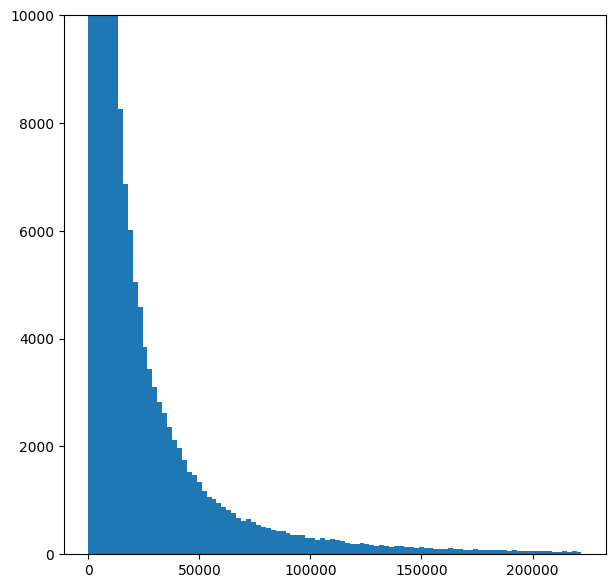

In [13]:
result['total_dur'].hist(bins=100, figsize=(7,7))
plt.ylim([0, 10000])
plt.grid(False)

In [14]:
def generate_salt():
    """
    Генерирует случайную соль и кодирует ее в base64.

    Returns:
    str: Сгенерированная соль в виде строки.
    """
    salt = os.urandom(8)
    return b64encode(salt).decode('ascii')

def get_bootstrap_sample(arr):
    """
    Создает случайные выборки с возвратом из массива.

    Args:
    arr (numpy.ndarray): Входной массив.

    Returns:
    numpy.ndarray: Массив случайных выборок.
    """
    return np.random.choice(arr, replace=True, size=len(arr))

def calculate_bootstrap_means(arr, size=1000):
    """
    Вычисляет средние значения для бутстрэп-выборок из массива.

    Args:
    arr (numpy.ndarray): Входной массив.
    size (int, optional): Количество итераций бутстрэпа. По умолчанию 1000.

    Returns:
    numpy.ndarray: Массив средних значений для каждой итерации бутстрэпа.
    """
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_sample(arr))
    return result

In [15]:


def groups_splitter(df: pd.DataFrame, columns: list, user_salt=None):
    """
    Разделяет группы пользователей на основе хэша, созданного из 'user_id' и соли.

    Args:
    df (pandas.DataFrame): Входной DataFrame с информацией о пользователях.
    columns (list): Список столбцов, которые нужно вернуть в итоговом DataFrame.
    user_salt (str, optional): Соль пользователя для создания хэша. Если не указана, генерируется случайная соль.

    Returns:
    pandas.DataFrame: DataFrame с уникальными пользователями и указанными столбцами.
    """
    salt = user_salt or generate_salt()
    

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())
    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()


def calc_bootstrap_mean(arr, size=1000):
    """
    Вычисляет среднее значение для бутстрэп-выборок из массива.

    Args:
    arr (numpy.ndarray): Входной массив.
    size (int, optional): Количество итераций бутстрэпа. По умолчанию 1000.

    Returns:
    numpy.ndarray: Массив средних значений для каждой итерации бутстрэпа.
    """
    indices = np.random.randint(0, len(arr), (size, len(arr)))
    bootstrap_samples = arr[indices]
    result = np.mean(bootstrap_samples, axis=1)
    return result

def get_p_value(dist):
    """
    Вычисляет p-value для распределения.

    Args:
    dist (numpy.ndarray): Распределение для вычисления p-value.

    Returns:
    float: Значение p-value.
    """
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue


In [38]:
# Параметры
num_iterations = 1000
bootstrap_size = 1000

# Инициализация списков для результатов
correctness = []
values = []

for _ in range(num_iterations):
    # Создание нового DataFrame с разделением групп
    new_df = groups_splitter(week2.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=generate_salt()).drop_duplicates()

    # Выделение данных для групп A и B
    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']

    # Бутстрап для групп A и B
    sample_a_mean = calc_bootstrap_mean(vec_a.values, size=bootstrap_size)
    sample_b_mean = calc_bootstrap_mean(vec_b.values, size=bootstrap_size)

    # Вычисление разницы между средними значениями
    values.append(sample_a_mean - sample_b_mean)

    # Рассчет 95% доверительного интервала для разницы средних
    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])

    # Запись результатов теста
    correctness.append(not left_side <= 0 <= right_side)

# Вычисление значимости
test_correctness = collections.Counter(correctness)
significance = test_correctness[1] / (test_correctness[1] + test_correctness[0]) * 100 if (test_correctness[1] + test_correctness[0]) != 0 else "Невозможно вычислить"

# Вывод результатов
print(f'significance: {significance}%')

significance: 7.5%


Таким образом можно утверждать, что есть статистически значимая разница между группами A и B с вероятностью 7.5% за две недели и 5% за одну неделю. **Изменения в данных не могут быть объяснены случайностью, и различия между группами считаются статистически значимыми.**


### Проверю на равномерность с помощью критерия Колмогорова-Смирнова

In [46]:
p_values = [get_p_value(dist) for dist in values]

In [48]:
stat, p_value = scipy.stats.kstest(p_values, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

p_value = 0.18017405204974213 - p_values равномерное распределение


### 3. На двух неделях посчитаем мощность. Для этого в одну из групп докинем эффект. Докинем эффект в 1%, 3% и 5% и сравним полученную мощность


In [42]:
# Параметры
effects = [0.01, 0.03, 0.05]
num_iterations = 1000
bootstrap_size = 1000

# Инициализация списков для результатов
correctness = [[] for _ in range(len(effects))]
values = [[] for _ in range(len(effects))]

# Основной цикл
for _ in range(num_iterations):
    # Создание нового DataFrame с разделением групп
    new_df = groups_splitter(week2.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=generate_salt()).drop_duplicates()

    # Выделение данных для групп A и B
    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']

    # Бутстрап для группы A
    sample_a_mean = calc_bootstrap_mean(vec_a, size=bootstrap_size)

    # Бутстрап для каждого значения эффекта в группе B
    for idx, effect in enumerate(effects):
        sample_b_mean = calc_bootstrap_mean(vec_b * effect, size=bootstrap_size)
        values[idx].append(sample_a_mean - sample_b_mean)

        # Рассчет интервала достоверности
        left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])

        # Запись результатов теста
        correctness[idx].append(not left_side <= 0 <= right_side)

# Вывод результатов
for idx, effect in enumerate(effects):
    test_correctness = collections.Counter(correctness[idx])
    power = test_correctness[1] / (test_correctness[1] + test_correctness[0]) * 100 if (test_correctness[1] + test_correctness[0]) != 0 else "Невозможно вычислить"
    print(f'Мощность при эффекте в {round((effect - 1) * 100)}%: {power}%')


Мощность при эффекте в 1%: 15.7%
Мощность при эффекте в 3%: 68.60000000000001%
Мощность при эффекте в 5%: 97.6%


In [56]:
result_power = pd.DataFrame([[0.157, 0.686, 0.976]], index=["Мощность"], columns=["effect_1.0%", "effect_3.0%", "effect_5.0%"])
powers = result_power.loc["Мощность"].values
result_power

,effect_1.0%,effect_3.0%,effect_5.0%
Мощность,0.157,0.686,0.976


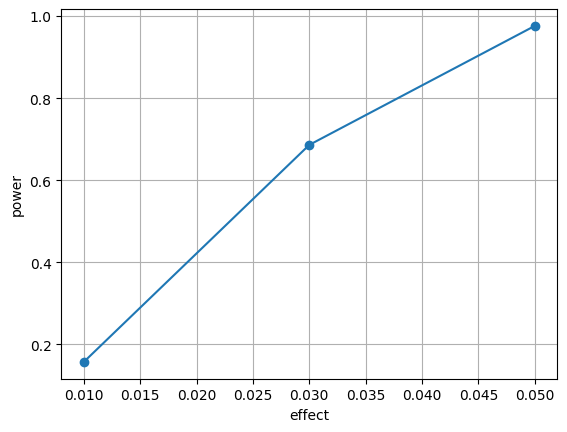

In [59]:
plt.plot(
    effects,
    powers,
    marker="o"
)
plt.xlabel("effect")
plt.ylabel("power")
plt.grid()

### 4. Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test

In [65]:
def get_mde(metric_vec, alpha=0.05, beta=0.2):
    
    metric_mean, metric_std, metric_num = metric_vec.mean(), metric_vec.std(), len(metric_vec)
    
    z_alpha = stats.norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    
    mde = (z_alpha + z_beta) * metric_std / np.sqrt(metric_num)
    
    return mde * 100 / metric_mean

Используем бутстреп для расчета мощности, и поскольку бутстреп не обязательно предоставляет конкретные значения эффекта, проведем линейную аппроксимацию между двумя близкими значениями эффекта, которые использовались при расчете мощности, для получения оценки MDE при мощности 0.8.

In [63]:
k = (powers[2] - powers[0]) / (effects[2] - effects[0])
b = powers[2] - effects[1] * k

power_needed = 0.8
mde = (power_needed - b) / k
print(f"MDE = {mde * 100:0.5}%")

MDE = 2.1404%


## A/B тест

1. Представим что у нас прошел тест, используем те же самые данные за 2 недели
2. Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (0.5 балла)

In [67]:
week2_ab = week2.copy()
week2_ab.loc[week2_ab["total_dur"] < 500, "total_dur"] = 0
pd.concat([week2_ab.head(), week2_ab.tail()])

,user_id,item_id,last_watch_dt,total_dur,watched_pct
6,1016458,354,2021-08-14,1672,25.0
9,203219,13582,2021-08-22,6975,100.0
22,505244,15297,2021-08-15,15991,63.0
24,916352,12846,2021-08-12,1812,30.0
30,1057871,6208,2021-08-12,5033,95.0
5476215,204332,2081,2021-08-10,822,14.0
5476222,1007900,9728,2021-08-12,0,6.0
5476246,648596,12225,2021-08-13,0,0.0
5476248,697262,15297,2021-08-20,18307,63.0
5476250,319709,4436,2021-08-15,3921,45.0


### Разобем пользователей на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805'

In [73]:
salt = "kiontestmodel20210805"
ab_df = groups_splitter(df=week2_ab, columns=["user_id", "total_dur", "group"], user_salt="kiontestmodel20210805")
pd.concat([ab_df.head(), ab_df.tail()])

,user_id,total_dur,group
6,1016458,1672,A
9,203219,6975,B
22,505244,15991,A
24,916352,1812,A
30,1057871,5033,A
5476215,204332,822,B
5476222,1007900,0,A
5476246,648596,0,B
5476248,697262,18307,A
5476250,319709,3921,A


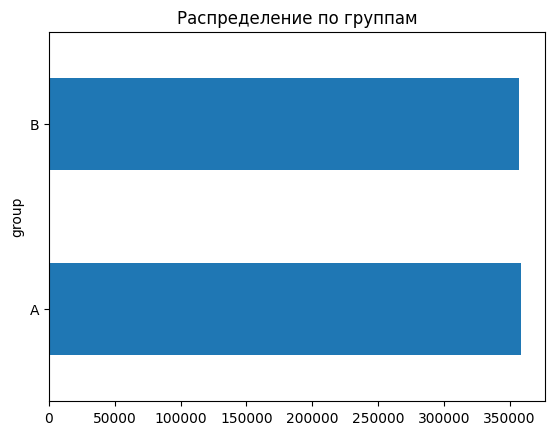

In [74]:
ab_df["group"].value_counts().plot.barh()
plt.title("Распределение по группам");

In [79]:
vec_a = week2_ab[(week2_ab['group'] == 'A')]['total_dur']
vec_b = week2_ab[(week2_ab['group'] == 'B')]['total_dur']

### Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением.

In [81]:
top_10_users_idx = vec_b.sort_values(ascending=False).index[:int(vec_b.shape[0] * 0.1)]
vec_b = vec_b.copy()  # Создаем явную копию DataFrame
vec_b.loc[top_10_users_idx] *= 1.025


In [87]:
def calculate_confidence_interval(distribution, alpha=0.05):
    """Вычисляет доверительный интервал для заданного уровня значимости."""
    lower_bound, upper_bound = np.percentile(distribution, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return lower_bound, upper_bound

In [88]:
# Рассчитываем средние для векторов с использованием бутстрэпа
sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)

# Вычисляем разности между средними значениями
difference_distribution = sample_a_mean - sample_b_mean

# Вычисляем доверительный интервал для разницы средних
lower_bound, upper_bound = calculate_confidence_interval(difference_distribution, alpha=0.05)

# Вычисляем p-value
p_value = get_p_value(difference_distribution)

# Печатаем результаты
print("95% Доверительный интервал для разницы средних:", (lower_bound, upper_bound))
print("p-value:", p_value)
print("Нулевая гипотеза (разница равна 0) отвергается:", not (lower_bound <= 0 <= upper_bound))

95% Доверительный интервал для разницы средних: (-361.3699729553779, -33.83579571457577)
p-value: 0.018
Нулевая гипотеза (разница равна 0) отвергается: True


Значение True указывает, что ноль находится внутри 95% доверительного интервала. В данном контексте это означает, что разница средних значений не является статистически значимой (по уровню значимости 0.05), так как 0 не входит в интервал.
Можно сделать следующий вывод: 
### **на основе проведенного бутстрэп-анализа с уровнем доверия 95%, разница средних значений между двумя выборками не является статистически значимой.**

In [89]:
if p_value < 0.05:
    print(f'p_value = {p_value} - Есть статистически значимые изменения')
else:
    print(f'p_value = {p_value} - Нет статистически значимых изменений')

p_value = 0.018 - Есть статистически значимые изменения


Это означает, что на уровне значимости 0.05 у нас есть статистически значимые доказательства того, что разница между средними значениями в выборках не случайна, и мы можем отвергнуть нулевую гипотезу в пользу альтернативной

### Посмотрим на распределение средних двух выборок

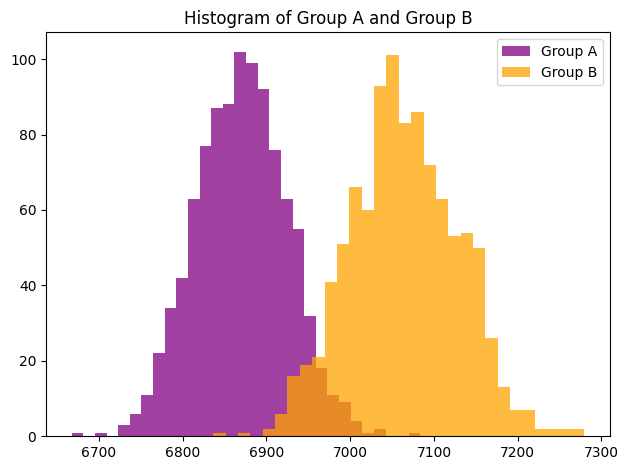

In [86]:

plt.hist(sample_a_mean, bins=30, color='purple', alpha=0.75, label='Group A')
plt.hist(sample_b_mean, bins=30, color='orange', alpha=0.75, label='Group B')
plt.title('Histogram of Group A and Group B')
plt.legend()
plt.tight_layout()
plt.show()